In [31]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import datetime as dt
import json
import time
from oura import OuraClient
from pymongo import MongoClient
import pymongo
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, mean_absolute_percentage_error, median_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
import math
from random import randint


In [32]:
#bitmask = []
#ideal_trend = []
#total_sprints = 40
#
#for i in range(total_sprints):
#    regular_sprint_time = 30*100 # total time of a run (sprint + recovery time)
#    long_recovery = 900*100      # interval recovery time
#    first_half_sprints = 20  # number of sprints in the first half
#    
#    sprint_time = regular_sprint_time if i != first_half_sprints else long_recovery # sprint time is always = regular_sprint_time, only for the last sprint of first time is = long_recovery
#    
#    random_n = 10*(randint(0,3))  # get the crono time
#    time = 12*100 + random_n
#    for i_1 in range(time):   
#        bitmask.append(1)     # add a 1 in the bitmask while the athlete is running
#    for i_2 in range(sprint_time -(time)):
#        bitmask.append(0)     # add a 0 in the bitmask while the athlete is recovering
#
#zero_counter = 0 
#ti = 0     # exponential exponent
#prov = 100 # scaling
#
#for t in range(1,len(bitmask)):
#    ti = ti + 1
#    if(t == regular_sprint_time*first_half_sprints + long_recovery): # setting after the interval
#        ti = 0
#        prov =ideal_trend[-1]
#
#    if( bitmask[t-1] == 1):      # run phase 
#        
#        x = prov*0.998**(ti/100)
#        zero_counter = 0
#
#    else:                        #recovery phase
#        zero_counter = (zero_counter + 1)
#        if (zero_counter/100 < 10):
#            p = ((zero_counter + 1)/100) / 20000
#        elif((zero_counter + 1)/100 < 100):
#            p = np.round(-0.5 + 1/(1+ np.exp(-zero_counter/1000000)),2)
#        elif((zero_counter + 1)/100 < 1000):
#            p = np.round(-0.5 + 1/(1+ np.exp(-zero_counter/10000000)),2)
#        elif((zero_counter + 1)/100< 2000):
#            p = np.round(-0.5 + 1/(1+ np.exp(-zero_counter/10000000)),2)
#        elif((zero_counter + 1)/100 < 10000):
#            p = np.round(-0.5 + 1/(1+ np.exp(-zero_counter/10000000)),2)
#
#        x = ideal_trend[-1] + p*1.001**(zero_counter)
#        if(x > 100):
#            x = 100
#    ideal_trend.append(x)
#    
#plt.figure(figsize=(15,8))
#plt.plot(ideal_trend)
#plt.show()

In [33]:
#lista = []
#idx = []
#points = []
#
#sprint_idx = []
#sprint_points = []
#
#
#all_points = []
#all_idx = []
#
#idx.append(0)
#points.append(100)
#
#sprint_idx.append(10)
#sprint_points.append(60)
#
#for t in range(1,3000):
#    x = 20 + 80*0.999**(t)
#    lista.append(x)
#    if(t > 1500):
#        x = 20 + 80*0.999**(t-1000)
#        lista[-1] = x
#        
#    if(t%40 == 0):
#        idx.append(t)
#        points.append(x)
#        sprint_idx.append(t + 10)
#        random_num = np.round(randint(1,30)/100,2)
#        sprint_contribute = x - (x*(0.2+random_num))
#        sprint_points.append(sprint_contribute)
#        new_extreme_point =  points[-1] - (sprint_contribute)
#
#        points[-1] = x - ((x-x*0.2) - (sprint_contribute))
#
#        if(new_extreme_point > 0):
#            sprint_points[-1] = new_extreme_point
#        else: 
#            sprint_points[-1] = 0
#
#
#plt.figure(figsize=(15,8))
#plt.plot(lista)
#plt.scatter(idx, points, color='orange')
#plt.scatter(sprint_idx, sprint_points, color='red')
#
#for i in range(len(points)):
#    
#    all_points.append(points[i])
#    all_points.append(sprint_points[i])
#
#    all_idx.append(idx[i])
#    all_idx.append(sprint_idx[i])
#
#plt.plot(all_idx, all_points)
#plt.show()

# Getting CSVs

In [34]:
location_30s = './Data/trainings_70m_30s.csv'
location_40s = './Data/trainings_70m_40s.csv'
location_60s = './Data/trainings_70m_60s.csv'

df_30s = pd.read_csv(location_30s)
df_40s = pd.read_csv(location_40s)
df_60s = pd.read_csv(location_60s)

In [35]:
metrics_df = pd.DataFrame(columns = ['algorithm','MAE', 'MSE','MAPE','MedAE','elapsed time'])

In [37]:
dfs = [df_30s,df_40s, df_60s] # list of all dfs
catenated_df = pd.concat(dfs) # create the catenated df
catenated_df = catenated_df.drop('Unnamed: 0',axis=1) #remove a fictious column autogenerated (redundant indexes)
catenated_df = catenated_df.drop('starting_stamina',axis=1) #remove a fictious column autogenerated (redundant indexes)
catenated_df = catenated_df.drop('peak_stamina',axis=1) #remove a fictious column autogenerated (redundant indexes)

In [39]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [40]:
catenated_df

time  sense  starting bpm  ending bpm  max_bpm  median bpm  mean_bpm  \
0    10.97      0         148.0       157.0    158.0      155.33    155.33   
1    10.90      1         157.0       158.0    161.0      159.20    159.20   
2    11.50      0         158.0       165.0    165.0      163.40    163.40   
3    11.97      1         166.0       166.0    167.0      165.73    165.73   
4    11.87      0         166.0       161.0    168.0      165.37    165.37   
5    12.40      1         160.0       170.0    170.0      166.33    166.33   
6    13.18      0         170.0       169.0    170.0      169.63    169.63   
7    12.81      1         169.0       165.0    169.0      168.13    168.13   
8    13.15      0         164.0       172.0    172.0      168.20    168.20   
9    13.28      1         172.0       174.0    175.0      173.87    173.87   
10   14.50      0         173.0       175.0    176.0      174.80    174.80   
11   13.66      1         175.0       177.0    178.0      176.17    176.17   
12   14.40      0         176.0       176.0    178.0      176.70    176.70   
13   14.28      1         175.0       174.0    176.0      175.37    175.37   
14   14.72      0         173.0       171.0    173.0      172.17    172.17   
15   14.06      1         170.0       166.0    170.0      169.53    169.53   
16   15.31      0         166.0       168.0    169.0      166.80    166.80   
17   15.00      1         168.0       165.0    169.0      167.90    167.90   
18   17.22      0         164.0       167.0    168.0      166.20    166.20   
19   14.84      1         167.0       168.0    169.0      168.27    168.27   
20   12.37      0         168.0       168.0    171.0      169.50    169.50   
21   13.06      1         168.0       150.0    170.0      163.80    163.80   
22   12.78      0         111.0       133.0    133.0      125.47    125.47   
23   13.03      1         133.0       140.0    140.0      137.77    137.77   
24   14.34      0         140.0       149.0    150.0      145.87    145.87   
25   14.31      1         149.0       150.0    150.0      149.20    149.20   
26   17.57      0         150.0       147.0    150.0      148.20    148.20   
27   15.87      1         147.0       150.0    150.0      149.20    149.20   
28   16.94      0         150.0       156.0    156.0      153.23    153.23   
29   17.56      1         156.0       142.0    156.0      152.53    152.53   
30   18.59      0         140.0       126.0    140.0      135.17    135.17   
31   18.31      1         126.0       119.0    126.0      122.27    122.27   
32   13.75      0         119.0       110.0    119.0      114.83    114.83   
33   15.16      1         109.0       106.0    109.0      107.00    107.00   
34   12.38      0         132.0       140.0    144.0      140.10    140.10   
35   12.35      1         140.0       138.0    145.0      141.57    141.57   
36   12.00      0         138.0       143.0    147.0      143.27    143.27   
37   11.94      1         143.0       136.0    143.0      138.97    138.97   
38   12.60      0         136.0       141.0    148.0      143.77    143.77   
39   12.93      1         141.0       153.0    153.0      150.10    150.10   
40   13.13      0         153.0       160.0    161.0      158.27    158.27   
41   13.12      1         160.0       164.0    164.0      162.07    162.07   
42   13.41      0         164.0       166.0    166.0      164.80    164.80   
43   12.50      1         166.0       163.0    168.0      165.63    165.63   
44   13.31      0         163.0       167.0    167.0      165.80    165.80   
45   13.32      1         167.0       166.0    171.0      168.57    168.57   
46   12.97      0         166.0       171.0    173.0      170.40    170.40   
47   12.94      1         172.0       178.0    178.0      176.13    176.13   
48   13.91      0         178.0       182.0    185.0      182.73    182.73   
49   12.97      1         182.0       181.0    183.0      181.73    181.73   
50   12.66      0         18

In [41]:
catenated_df = catenated_df.dropna()
catenated_df = catenated_df.reset_index(drop=True)

In [42]:
catenated_df

time  sense  starting bpm  ending bpm  max_bpm  median bpm  mean_bpm  \
0    10.97      0         148.0       157.0    158.0      155.33    155.33   
1    10.90      1         157.0       158.0    161.0      159.20    159.20   
2    11.50      0         158.0       165.0    165.0      163.40    163.40   
3    11.97      1         166.0       166.0    167.0      165.73    165.73   
4    11.87      0         166.0       161.0    168.0      165.37    165.37   
5    12.40      1         160.0       170.0    170.0      166.33    166.33   
6    13.18      0         170.0       169.0    170.0      169.63    169.63   
7    12.81      1         169.0       165.0    169.0      168.13    168.13   
8    13.15      0         164.0       172.0    172.0      168.20    168.20   
9    13.28      1         172.0       174.0    175.0      173.87    173.87   
10   14.50      0         173.0       175.0    176.0      174.80    174.80   
11   13.66      1         175.0       177.0    178.0      176.17    176.17   
12   14.40      0         176.0       176.0    178.0      176.70    176.70   
13   14.28      1         175.0       174.0    176.0      175.37    175.37   
14   14.72      0         173.0       171.0    173.0      172.17    172.17   
15   14.06      1         170.0       166.0    170.0      169.53    169.53   
16   15.31      0         166.0       168.0    169.0      166.80    166.80   
17   15.00      1         168.0       165.0    169.0      167.90    167.90   
18   17.22      0         164.0       167.0    168.0      166.20    166.20   
19   14.84      1         167.0       168.0    169.0      168.27    168.27   
20   12.37      0         168.0       168.0    171.0      169.50    169.50   
21   13.06      1         168.0       150.0    170.0      163.80    163.80   
22   12.78      0         111.0       133.0    133.0      125.47    125.47   
23   13.03      1         133.0       140.0    140.0      137.77    137.77   
24   14.34      0         140.0       149.0    150.0      145.87    145.87   
25   14.31      1         149.0       150.0    150.0      149.20    149.20   
26   17.57      0         150.0       147.0    150.0      148.20    148.20   
27   15.87      1         147.0       150.0    150.0      149.20    149.20   
28   16.94      0         150.0       156.0    156.0      153.23    153.23   
29   17.56      1         156.0       142.0    156.0      152.53    152.53   
30   18.59      0         140.0       126.0    140.0      135.17    135.17   
31   18.31      1         126.0       119.0    126.0      122.27    122.27   
32   13.75      0         119.0       110.0    119.0      114.83    114.83   
33   15.16      1         109.0       106.0    109.0      107.00    107.00   
34   12.38      0         132.0       140.0    144.0      140.10    140.10   
35   12.35      1         140.0       138.0    145.0      141.57    141.57   
36   12.00      0         138.0       143.0    147.0      143.27    143.27   
37   11.94      1         143.0       136.0    143.0      138.97    138.97   
38   12.60      0         136.0       141.0    148.0      143.77    143.77   
39   12.93      1         141.0       153.0    153.0      150.10    150.10   
40   13.13      0         153.0       160.0    161.0      158.27    158.27   
41   13.12      1         160.0       164.0    164.0      162.07    162.07   
42   13.41      0         164.0       166.0    166.0      164.80    164.80   
43   12.50      1         166.0       163.0    168.0      165.63    165.63   
44   13.31      0         163.0       167.0    167.0      165.80    165.80   
45   13.32      1         167.0       166.0    171.0      168.57    168.57   
46   12.97      0         166.0       171.0    173.0      170.40    170.40   
47   12.94      1         172.0       178.0    178.0      176.13    176.13   
48   13.91      0         178.0       182.0    185.0      182.73    182.73   
49   12.97      1         182.0       181.0    183.0      181.73    181.73   
50   12.66      0         18

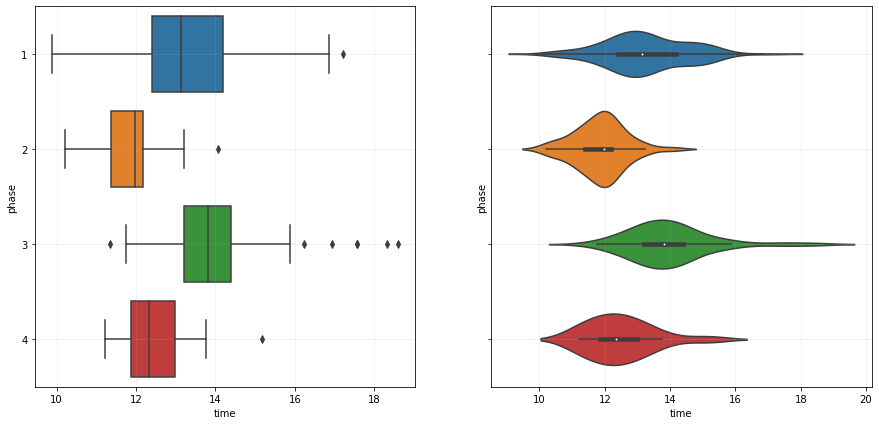

In [194]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharey=True)

sns.boxplot(ax=axes[0], data=catenated_df, x="time", y="phase", orient='h')
sns.violinplot(ax=axes[1], data=catenated_df, x="time", y="phase", orient='h')

axes[0].grid(alpha=0.2)
axes[1].grid(alpha=0.2)
plt.show()

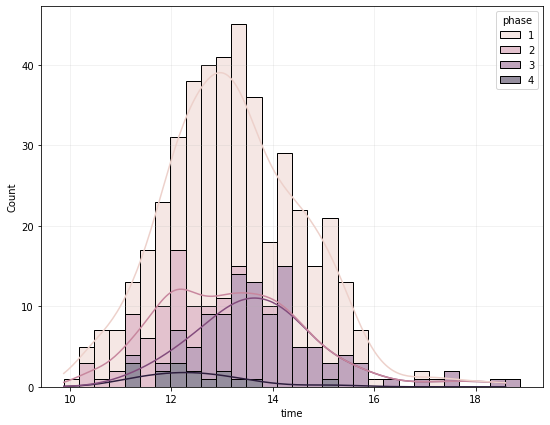

In [209]:
plt.figure(figsize=(9, 7))
sns.histplot(data=catenated_df, x='time', binwidth=0.3, hue="phase", multiple="stack", kde=True)

plt.grid(alpha=0.2)

plt.show()


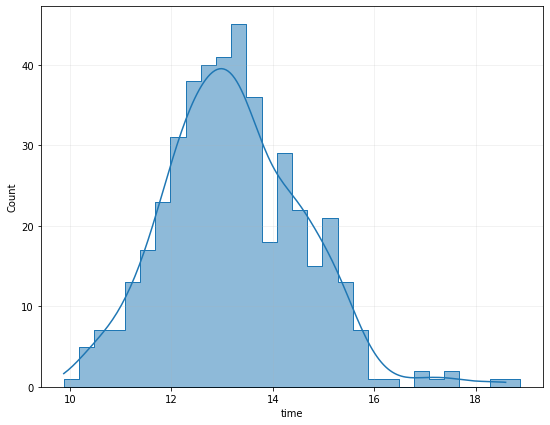

In [210]:
plt.figure(figsize=(9, 7))
sns.histplot(data=catenated_df, x='time', binwidth=0.3, kde=True, element="step")

plt.grid(alpha=0.2)

plt.show()


C:\Users\apanico\Miniconda3\envs\football\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


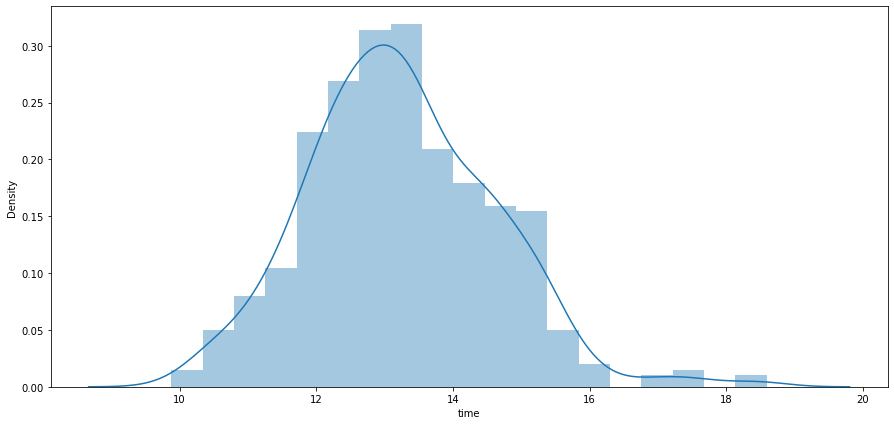

In [204]:
plt.figure(figsize=(15, 7))
sns.distplot(catenated_df.time.astype(float))
plt.show()

<Figure size 720x360 with 0 Axes>

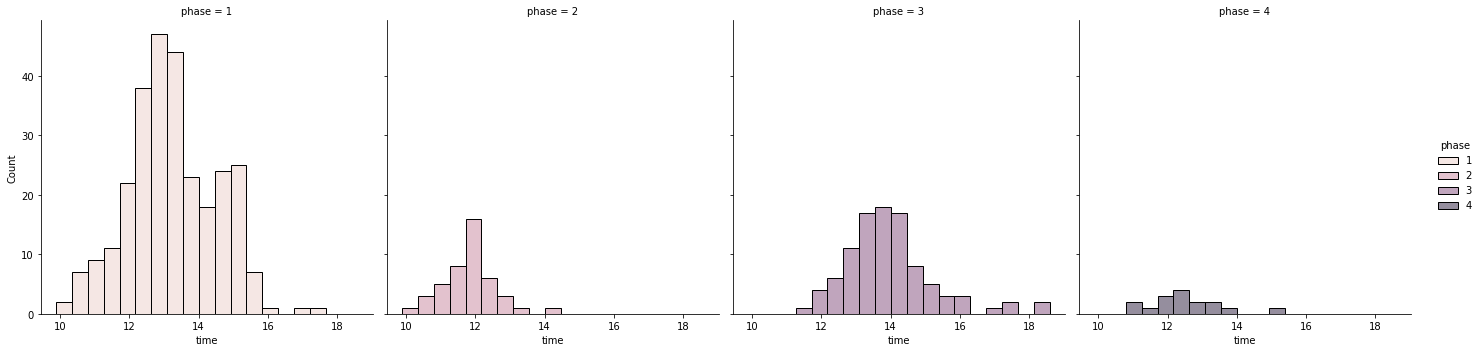

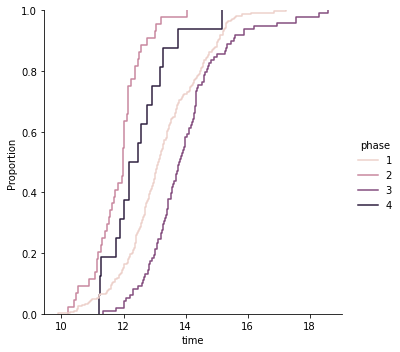

In [125]:
plt.figure(figsize=(10,5))
sns.displot(catenated_df, x='time', col='phase', hue='phase')
sns.displot(catenated_df, x="time", kind="ecdf", hue="phase")

plt.show()

<Figure size 720x360 with 0 Axes>

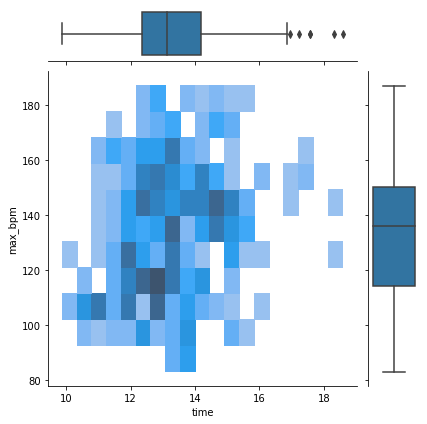

In [112]:
plt.figure(figsize=(10,5))
g = sns.JointGrid(data=catenated_df, x="time", y="max_bpm")
g.plot_joint(sns.histplot)
g.plot_marginals(sns.boxplot)
plt.show()

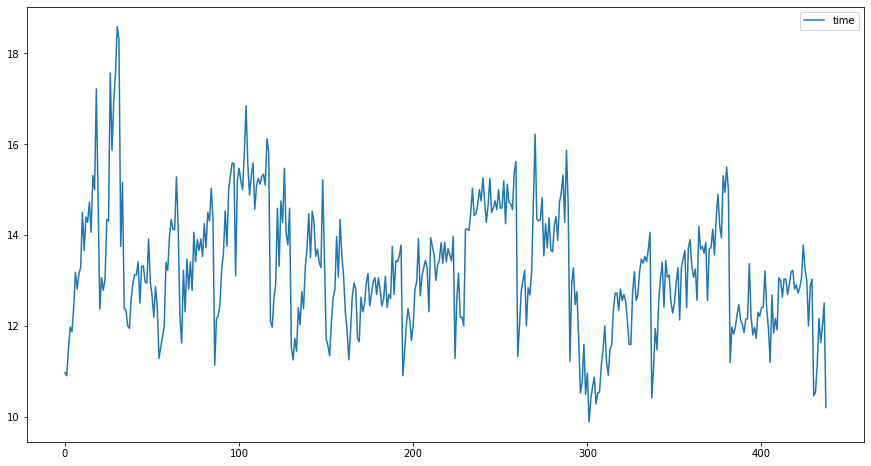

In [11]:
catenated_df[['time']].plot(figsize=(15,8))

# MODEL SELECTION

In [12]:
all_models = []

In [13]:
poly = PolynomialFeatures(degree=1)

## Multivariate Regression

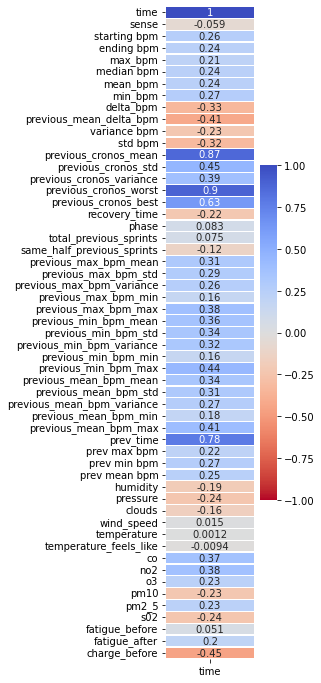

In [14]:
f, (ax1) = plt.subplots(1,1, figsize = (2,12))
correlation_matrix = catenated_df.corr(method = 'pearson')
sns.heatmap(correlation_matrix[['time']], annot=True,cmap='coolwarm_r', ax=ax1, linewidths=0.2, vmin=-1, vmax=1)
plt.show()

In [20]:
correlation_matrix = correlation_matrix[['time']]
relevant_columns = correlation_matrix[correlation_matrix.time.abs() > 0].index.tolist()
relevant_columns.remove('time')
relevant_columns.remove('ending bpm')
relevant_columns.remove('max_bpm')
relevant_columns.remove('median bpm')
relevant_columns.remove('mean_bpm')
relevant_columns.remove('min_bpm')
relevant_columns.remove('delta_bpm')
relevant_columns.remove('variance bpm')
relevant_columns.remove('std bpm')

catenated_df = catenated_df.sample(frac=1)

X = catenated_df.iloc[:,1:].loc[:,relevant_columns].values
y = catenated_df.iloc[:,0].values

In [ ]:
##transform the x data for proper fitting (for single variable type it returns,[1,x,x**2])
#
#poly_var_train, poly_var_test, res_train, res_test = train_test_split(X, y, test_size = 0.3)
#
##Scaling the input
#sc = StandardScaler()
#
#poly_var_train = sc.fit_transform(poly_var_train)
#poly_var_test = sc.transform(poly_var_test)

In [21]:
#transform the x data for proper fitting (for single variable type it returns,[1,x,x**2])
poly_var_train = X[:int(len(X)*0.6),:]
res_train = y[:int(len(y)*0.6)]

poly_var_cv = X[int(len(X)*0.6):int(len(X)*0.6) + int(len(X)*0.2),:]
res_cv = y[int(len(y)*0.6):int(len(y)*0.6) + int(len(y)*0.2)]

poly_var_test = X[int(len(X)*0.6) + int(len(X)*0.2):,:]
res_test = y[int(len(y)*0.6) + int(len(y)*0.2):]

#Scaling the input
sc = StandardScaler()

poly_var_train = sc.fit_transform(poly_var_train)
poly_var_cv = sc.transform(poly_var_cv)
poly_var_test = sc.transform(poly_var_test)

In [22]:
def fit_model(math_model, poly_var_train, poly_var_test, res_train, res_test, metrics_df, model_name, mode=1):
    
    elapsed_time = 0
    elapsed_time -= time.time()

    model = math_model.fit(poly_var_train, res_train)
    y_pred = model.predict(poly_var_test)
    
    elapsed_time += time.time()
    elapsed_time = np.round(elapsed_time,3)
    
    score = np.round(model.score(poly_var_test, res_test))
    MAE = np.round(mean_absolute_error(res_test, y_pred),2)
    MSE = np.round(mean_squared_error(res_test, y_pred),2)
    MAPE = np.round(mean_absolute_percentage_error(res_test, y_pred),2)
    MedAE = np.round(median_absolute_error(res_test, y_pred),2)

    if (mode == 2):
            df_line = pd.DataFrame([[model_name, MAE, MSE, MAPE, MedAE,elapsed_time]], columns=['degree','MAE', 'MSE','MAPE','MedAE','elapsed time'])
    else:
        df_line = pd.DataFrame([[model_name, MAE, MSE, MAPE, MedAE,elapsed_time]], columns=['algorithm','MAE', 'MSE','MAPE','MedAE','elapsed time'])
    metrics_df = pd.concat([metrics_df, df_line])
    metrics_df = metrics_df.reset_index(drop=True)

    return y_pred, metrics_df

In [23]:
def plot_comparison(y_pred, res_test, model, model_name, mode=1, metrics=metrics_df):
    plt.figure(figsize=(15,8))
    x_axis = np.arange(len(y_pred))

    #True values
    plt.scatter(x_axis, res_test, label='True values')
    plt.plot(x_axis, res_test)

    #Predicted
    plt.scatter(x_axis, y_pred, label='Predictions')
    plt.plot(x_axis, y_pred)

    if(mode == 1):
        MAPE = metrics_df.loc[metrics_df['algorithm'] == model_name].MAPE.values[0]
        MSE = metrics_df.loc[metrics_df['algorithm'] == model_name].MSE.values[0]
        plt.title('{}, MAPE :{}, MSE: {}'.format(model_name, MAPE,MSE))

    else:
        if(mode == 2):
            MAPE = metrics.loc[metrics['degree'] == model_name].MAPE.values[0]
            MSE = metrics.loc[metrics['degree'] == model_name].MSE.values[0]
            plt.title('Polynomial of degree: {}, MAPE :{}, MSE: {}'.format(model_name, MAPE,MSE))

    plt.xlabel('Sprint #')
    plt.ylabel('Times[s]')
    plt.legend()
    plt.show()
    

In [24]:
def plot_importance(model):
    # getting importance by model
    importances = pd.DataFrame(data={
        'Attribute': relevant_columns,
        'Importance': model.feature_importances_
    })
    importances = importances.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(18,10))
    plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
    plt.title('Feature importances obtained from coefficients', size=20)
    plt.xticks(rotation='vertical')
    plt.show()

In [25]:
import time
linear_model = LinearRegression()
all_models.append(linear_model)
linear_model_name ='Linear Regression'
y_linear_pred, metrics_df = fit_model(linear_model, poly_var_train, poly_var_cv, res_train, res_cv, metrics_df,linear_model_name)

### PLOT Multivariate Regression predicted vs True Values

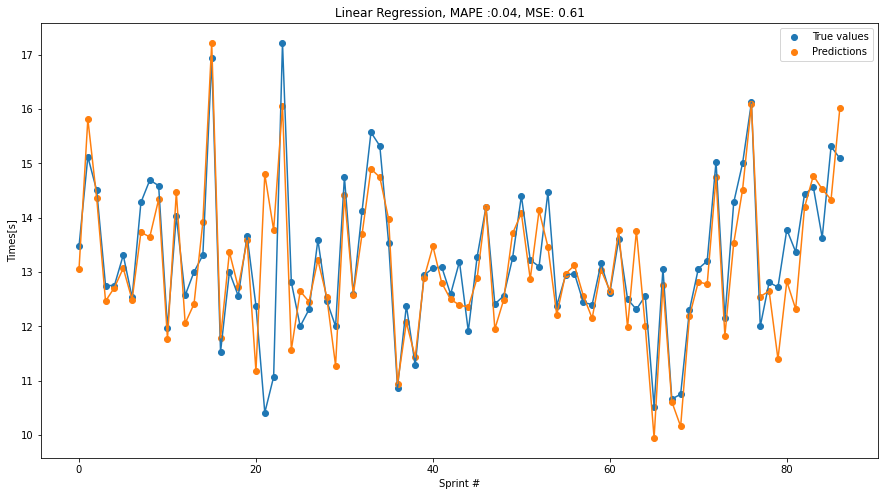

In [26]:
plot_comparison(y_linear_pred, res_cv, linear_model, linear_model_name)

###  Multivariate regression feature Importance?

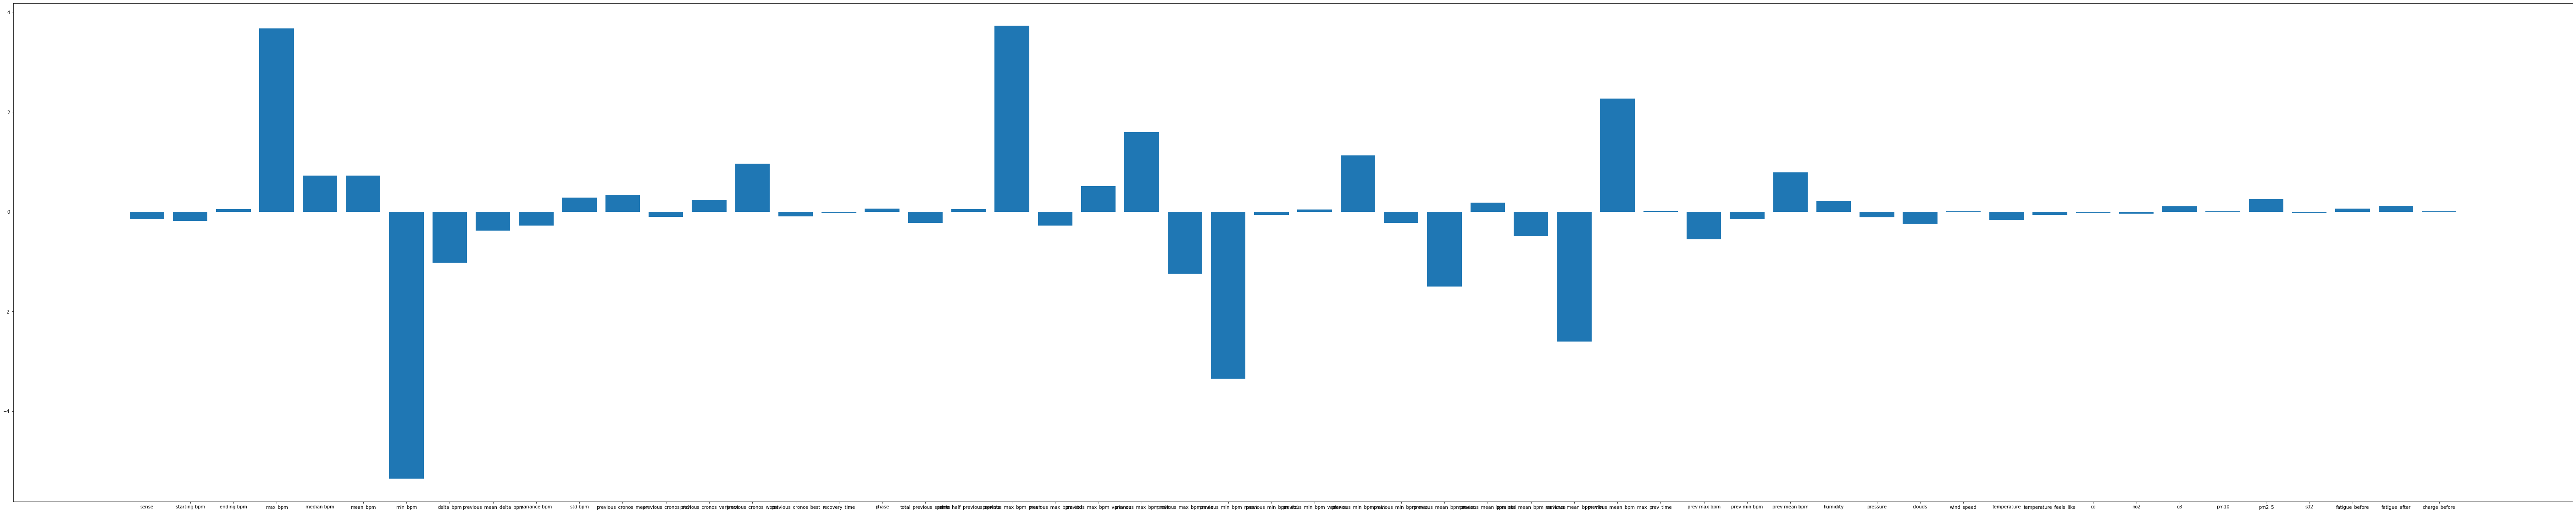

In [23]:
importance = linear_model.coef_
# summarize feature importance
plt.figure(figsize=(100,20))
plt.bar([x for x in relevant_columns], importance)
plt.show()

## Random Forest

In [24]:
random_forest_model = RandomForestRegressor()
all_models.append(random_forest_model)
rf_model_name ='Random Forest'
y_rf_pred, metrics_df = fit_model(random_forest_model, poly_var_train, poly_var_cv, res_train, res_cv, metrics_df,rf_model_name)

### PLOT Random forest predicted vs True values

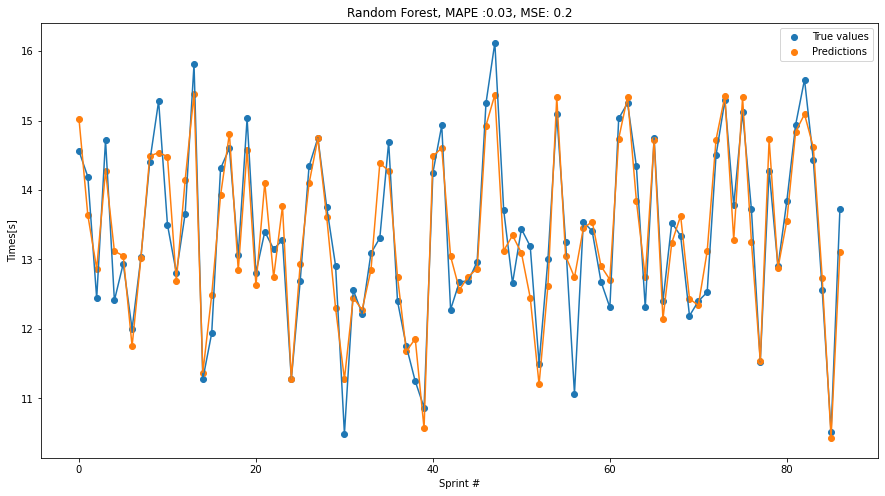

In [25]:
plot_comparison(y_rf_pred, res_cv, random_forest_model, rf_model_name)

### RANDOM FOREST features importance

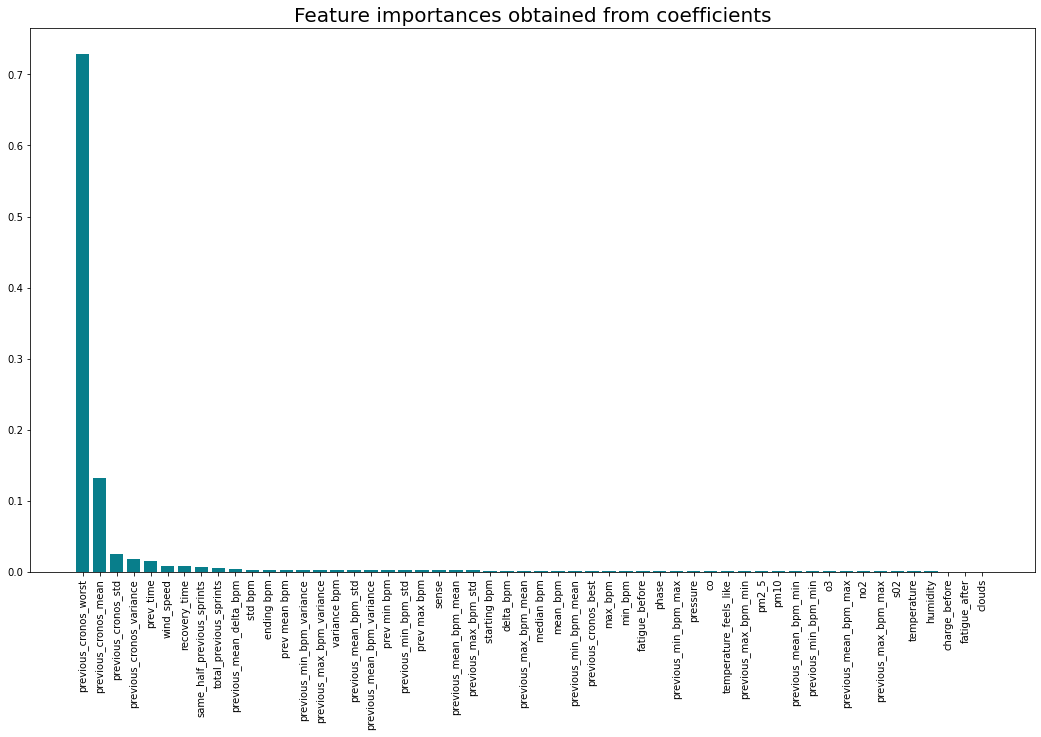

In [26]:
plot_importance(random_forest_model)

## Decision Tree

In [27]:
model_decision_tree = DecisionTreeRegressor()
all_models.append(model_decision_tree)
decision_tree_model_name ='Decision Tree'
y_dec_tree_pred, metrics_df = fit_model(model_decision_tree, poly_var_train, poly_var_cv, res_train, res_cv, metrics_df,decision_tree_model_name)

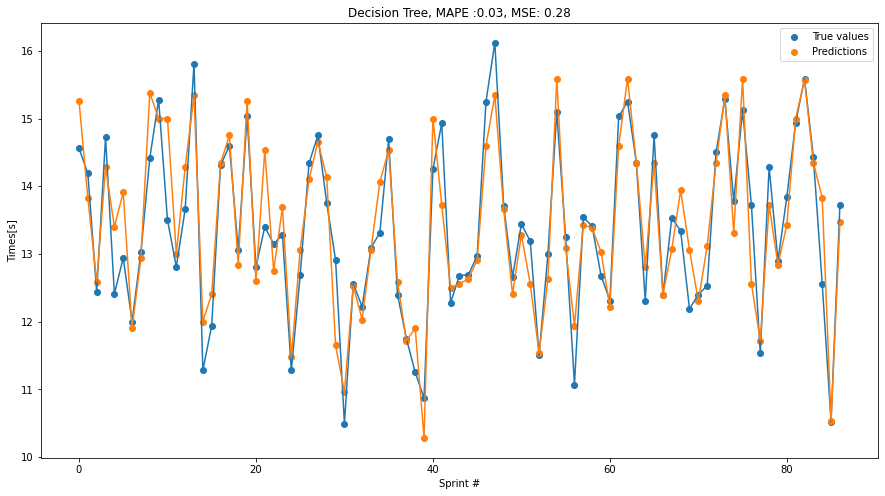

In [28]:
plot_comparison(y_dec_tree_pred, res_cv, model_decision_tree, decision_tree_model_name)

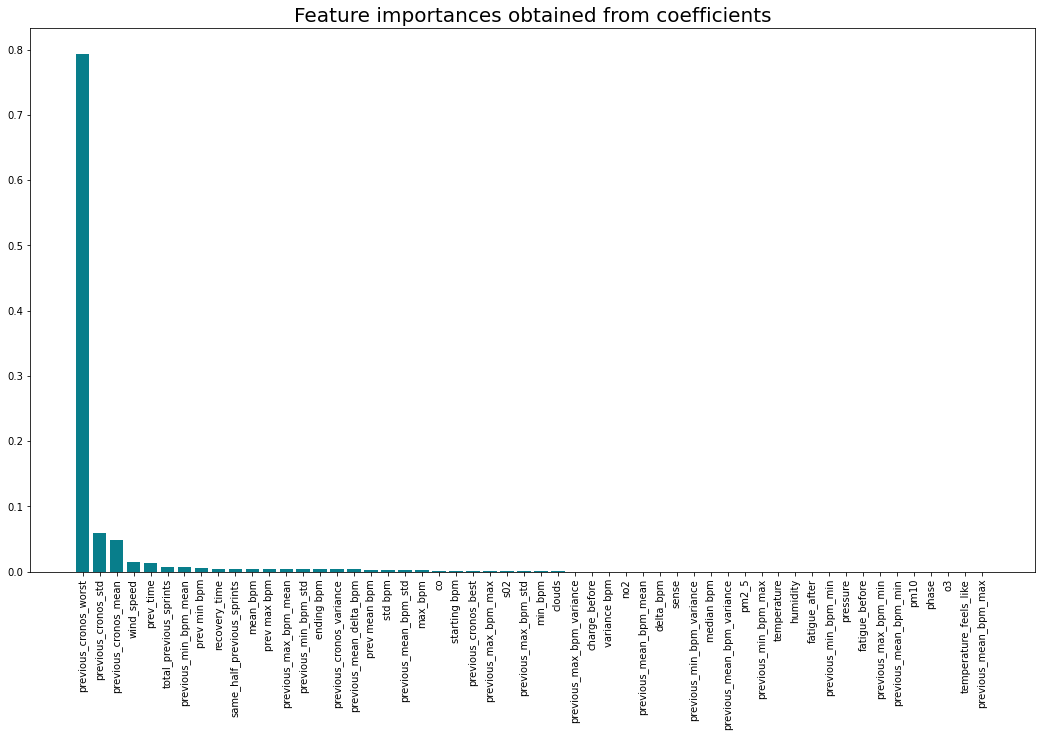

In [29]:
plot_importance(model_decision_tree)

## CART Regression

In [30]:
CART = DecisionTreeRegressor()
all_models.append(CART)
CART_model_name ='CART'
y_CART_pred, metrics_df = fit_model(CART, poly_var_train, poly_var_cv, res_train, res_cv, metrics_df,CART_model_name)

### PLOT CART predicted vs True values

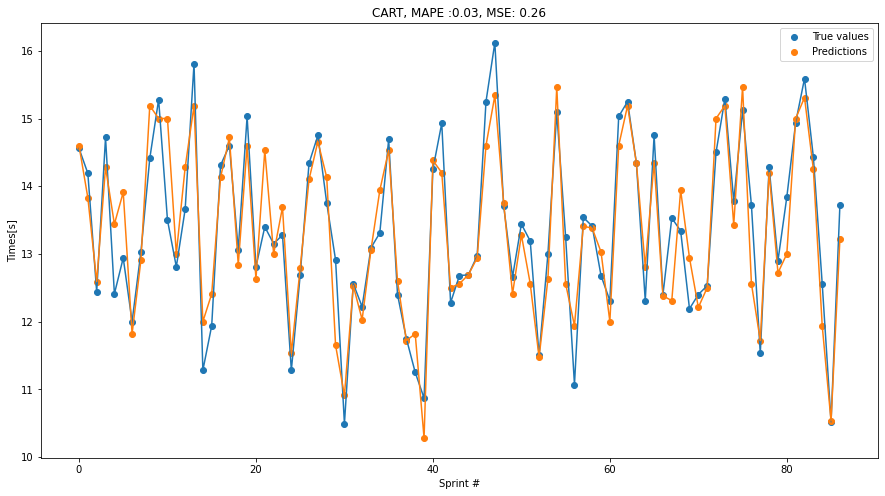

In [31]:
plot_comparison(y_CART_pred, res_cv, CART, CART_model_name)

### CART features importance

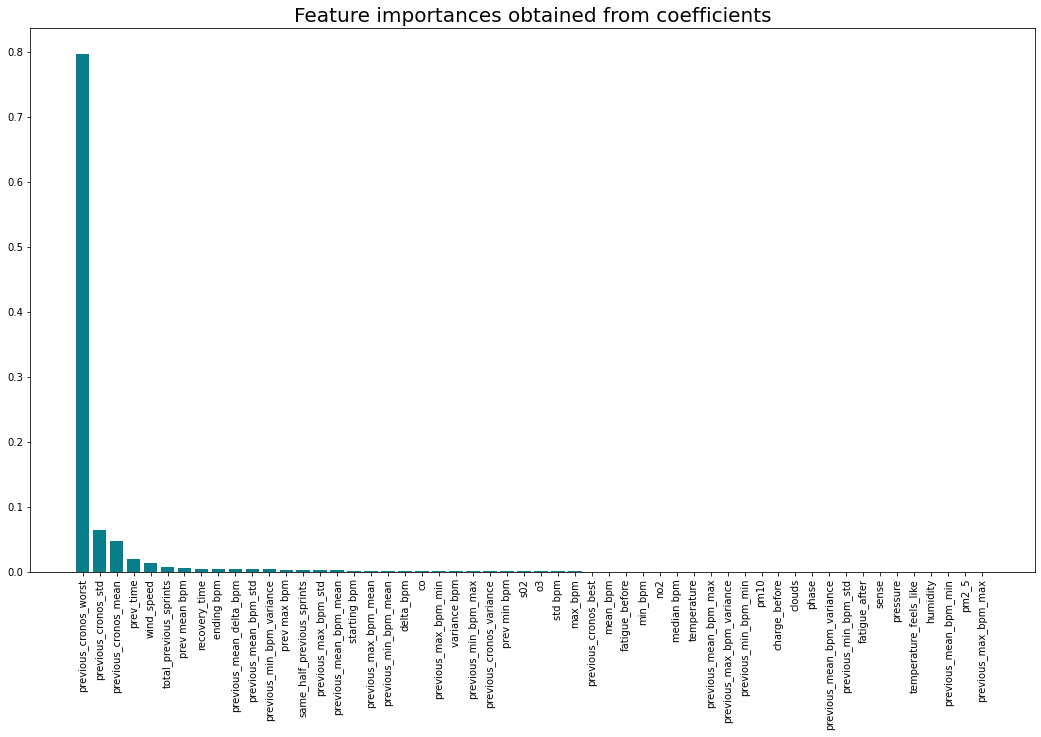

In [32]:
plot_importance(CART)

## XGBoost

In [33]:
XGBoost = XGBRegressor()
all_models.append(XGBoost)
XGBoost_model_name ='XGBoost'
y_XGBoost_pred, metrics_df = fit_model(XGBoost, poly_var_train, poly_var_cv, res_train, res_cv, metrics_df,XGBoost_model_name)

### PLOT XGBoost predicted vs True values

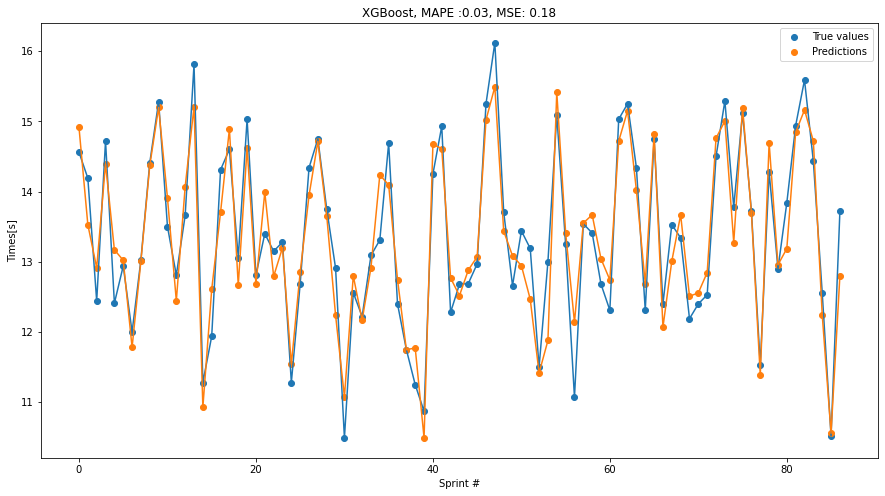

In [34]:
plot_comparison(y_XGBoost_pred, res_cv, XGBoost, XGBoost_model_name)

### XGBoost feature importance

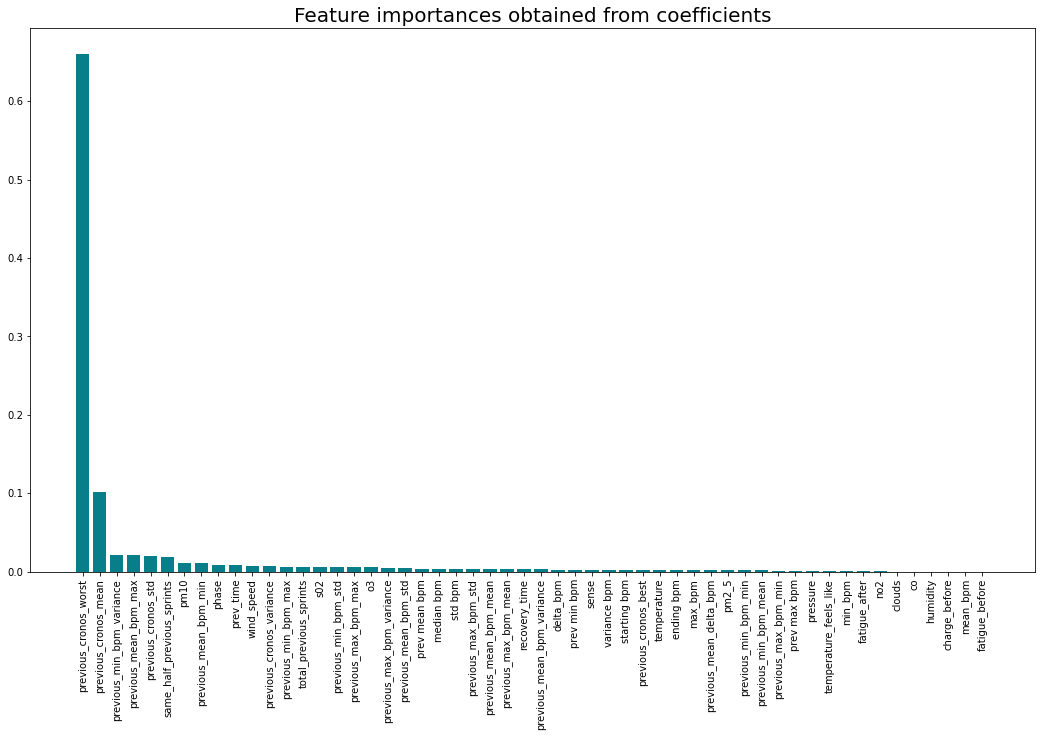

In [35]:
plot_importance(XGBoost)

## KNeighbors Regression

In [36]:
Kneigh = KNeighborsRegressor()
all_models.append(Kneigh)
Kneigh_model_name ='KNeighbors'
y_Kneigh_pred, metrics_df = fit_model(Kneigh, poly_var_train, poly_var_cv, res_train, res_cv, metrics_df,Kneigh_model_name)

### PLOT Kneighbors predicted vs True values

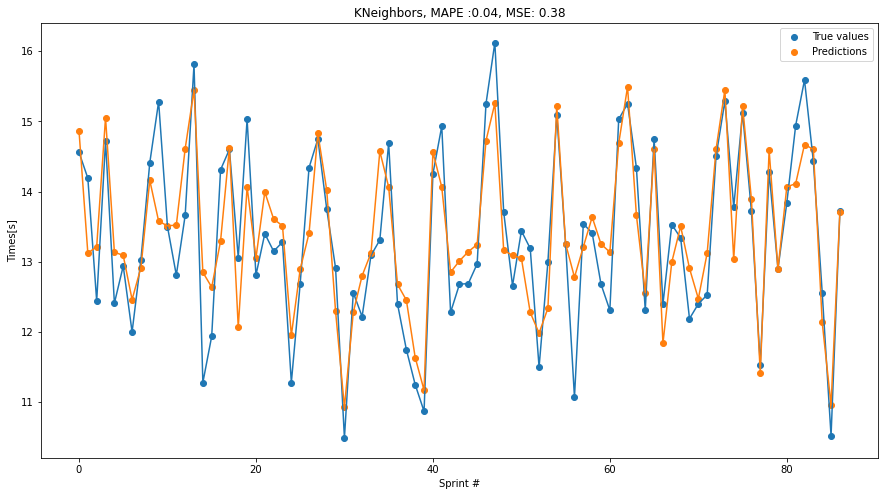

In [37]:
plot_comparison(y_Kneigh_pred, res_cv, Kneigh, Kneigh_model_name)

### Kneigh feature importance (the only one with permutation importance)

Permutation feature importance is a technique for calculating relative importance scores that is independent of the model used.

First, a model is fit on the dataset, such as a model that does not support native feature importance scores. Then the model is used to make predictions on a dataset, although the values of a feature (column) in the dataset are scrambled. This is repeated for each feature in the dataset. Then this whole process is repeated 3, 5, 10 or more times. The result is a mean importance score for each input feature (and distribution of scores given the repeats).

This approach can be used for regression or classification and requires that a performance metric be chosen as the basis of the importance score, such as the mean squared error for regression and accuracy for classification.

Permutation feature selection can be used via the permutation_importance() function that takes a fit model, a dataset (train or test dataset is fine), and a scoring function.

Let’s take a look at this approach to feature selection with an algorithm that does not support feature selection natively, specifically k-nearest neighbors.

In [38]:
results = permutation_importance(Kneigh,poly_var_train, res_train, scoring='neg_mean_squared_error')
# get importance
importance = results.importances_mean

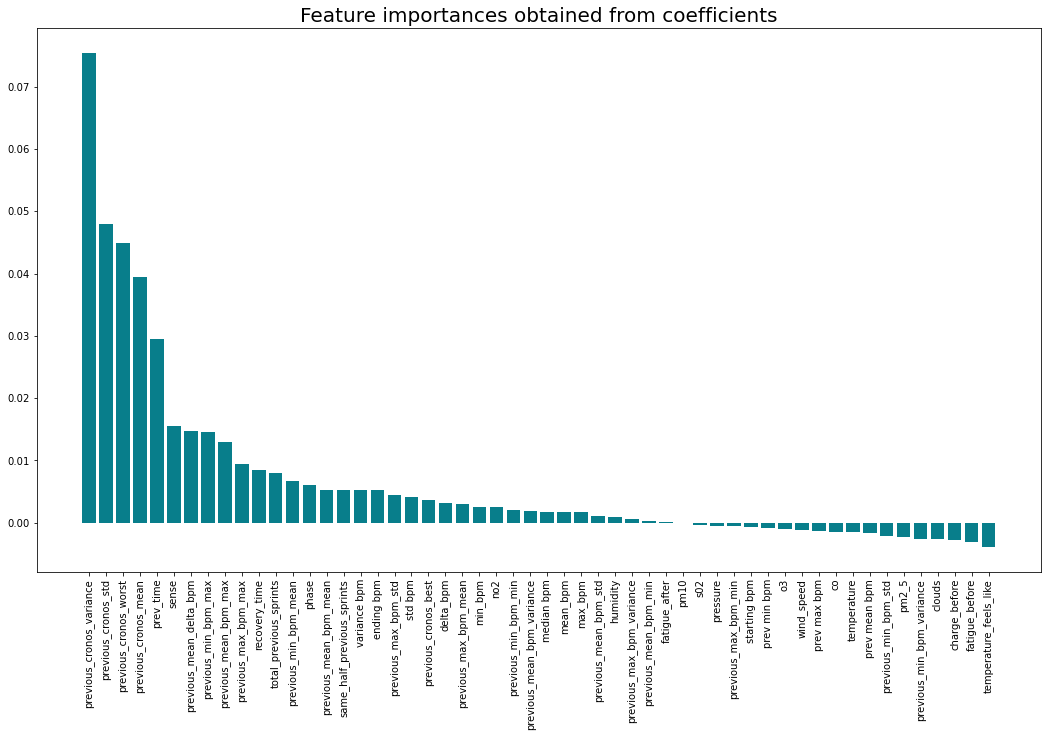

In [39]:
# getting importance by model
importances = pd.DataFrame(data={
    'Attribute': relevant_columns,
    'Importance': importance
})
importances = importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(18,10))
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

## RIDGE

In [40]:
ridge_model = Ridge(alpha=1)
all_models.append(ridge_model)
ridge_model_name ='Ridge'
y_ridge_pred, metrics_df = fit_model(ridge_model, poly_var_train, poly_var_cv, res_train, res_cv, metrics_df,ridge_model_name)

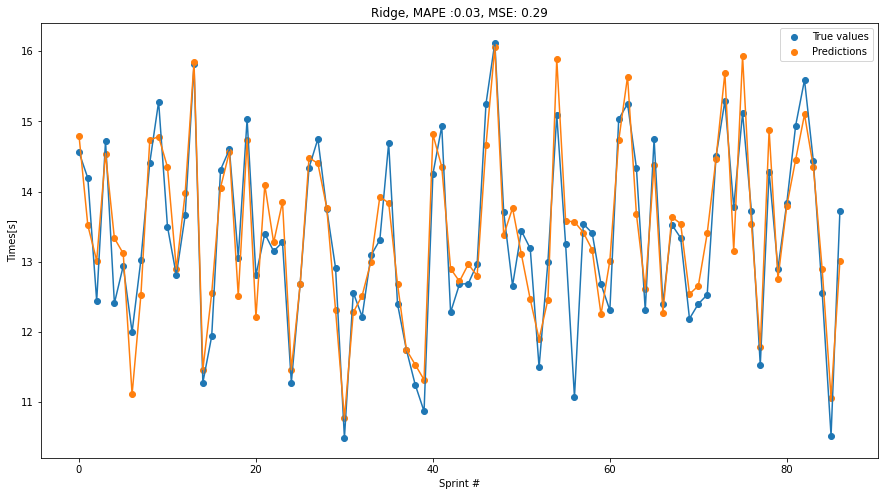

In [41]:
plot_comparison(y_ridge_pred, res_cv, ridge_model, ridge_model_name)

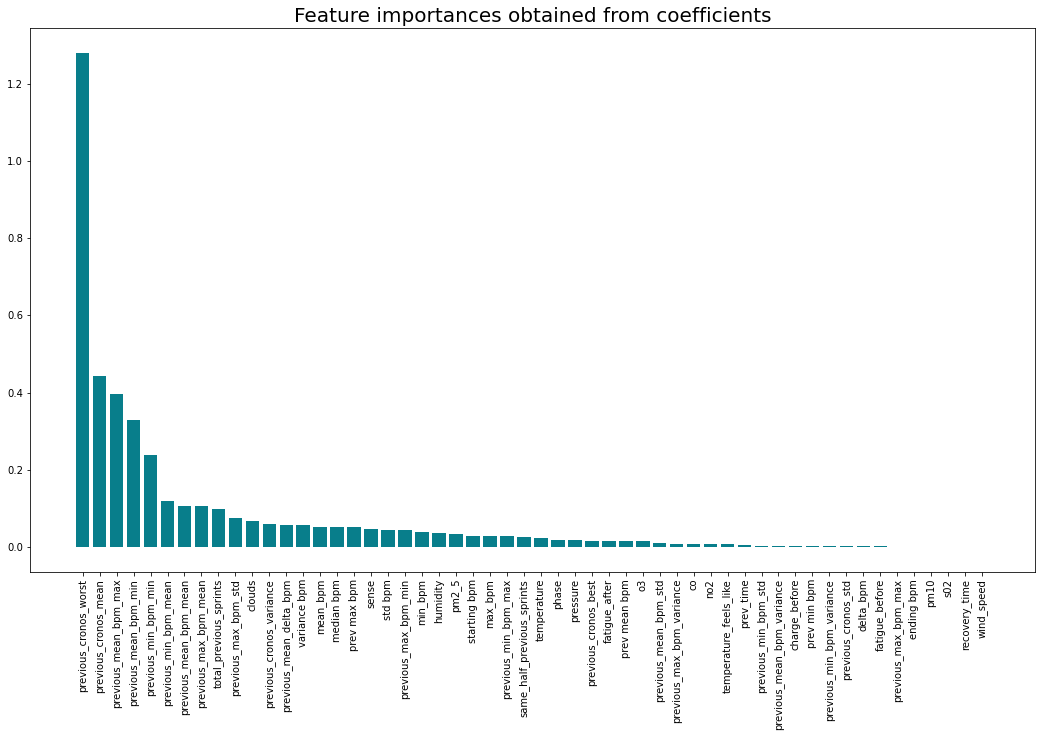

In [42]:
results = permutation_importance(ridge_model,poly_var_train, res_train, scoring='neg_mean_squared_error')
# get importance
importance = results.importances_mean

# getting importance by model
importances = pd.DataFrame(data={
    'Attribute': relevant_columns,
    'Importance': importance
})
importances = importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(18,10))
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

## Lasso

In [43]:
model_lasso = Lasso(alpha=0.01)
all_models.append(model_lasso)
lasso_model_name ='Lasso'
y_lasso_pred, metrics_df = fit_model(model_lasso, poly_var_train, poly_var_cv, res_train, res_cv, metrics_df,lasso_model_name)

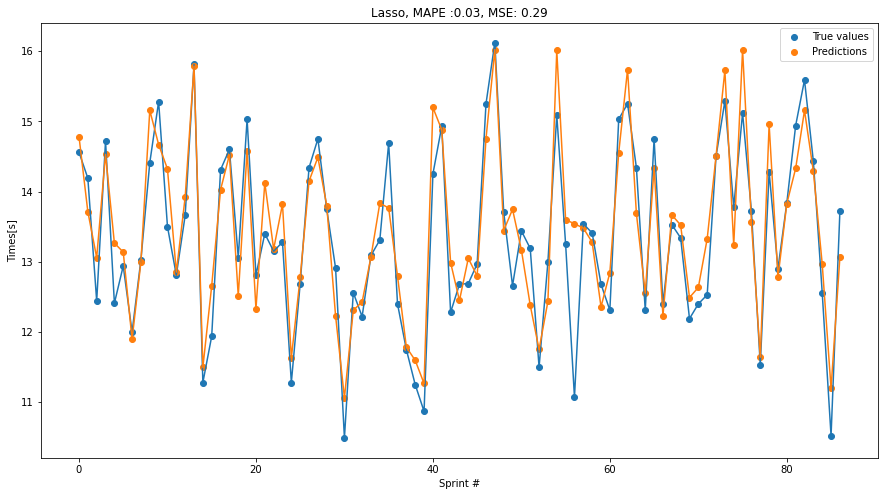

In [44]:
plot_comparison(y_lasso_pred, res_cv, model_lasso, lasso_model_name)

## ELASTIC-NET

In [45]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from numpy import absolute


elastic_net = ElasticNet(alpha=0.01, l1_ratio=0.5)
all_models.append(elastic_net)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
elastic_net_name ='Elastic Net'
scores = cross_val_score(elastic_net, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

y_el_net_pred, metrics_df = fit_model(elastic_net, poly_var_train, poly_var_cv, res_train, res_cv, metrics_df,elastic_net_name)

Mean MAE: 0.414 (0.045)


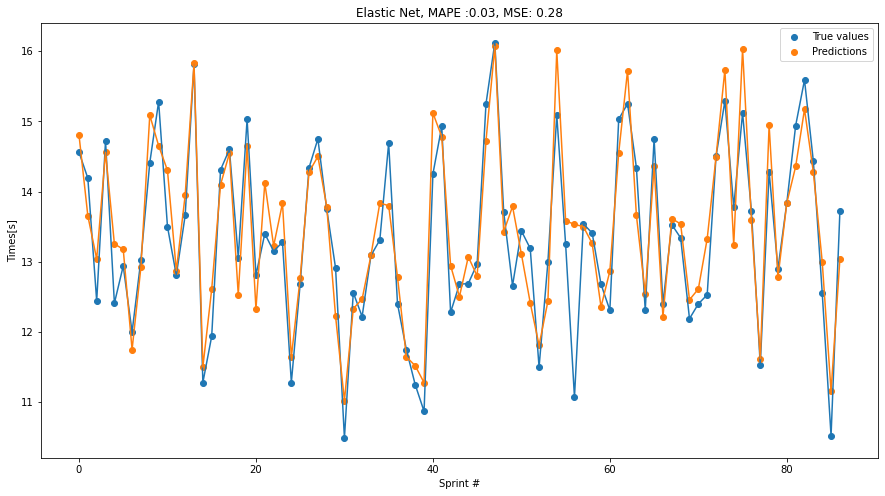

In [46]:
plot_comparison(y_el_net_pred, res_cv, elastic_net, elastic_net_name)

## Neural network Regression

In [47]:
# Initialising the ANN
model = Sequential()

# Adding the input layer and the first hidden layer
model.add(Dense(len(poly_var_train), activation = 'relu'))

# Adding the second hidden layer
model.add(Dense(units = len(poly_var_train), activation = 'relu'))

# Adding the third hidden layer
model.add(Dense(units = len(poly_var_train), activation = 'relu'))

# Adding the output layer
model.add(Dense(units = 1))

elapsed_time = 0
elapsed_time -= time.time()
    
model.compile(optimizer = 'adam',loss = 'mean_squared_error')
all_models.append(model)

model.fit(poly_var_train, res_train, batch_size = 5, epochs = 100)
y_pred = model.predict(poly_var_cv)

elapsed_time += time.time()
elapsed_time = np.round(elapsed_time,3)

MAE = np.round(mean_absolute_error(res_cv, y_pred),2)
MSE = np.round(mean_squared_error(res_cv, y_pred),2)
MAPE = np.round(mean_absolute_percentage_error(res_cv, y_pred),2)
MedAE = np.round(median_absolute_error(res_cv, y_pred),2)

df_line = pd.DataFrame([['Neural Network', MAE, MSE, MAPE, MedAE,elapsed_time]], columns=['algorithm','MAE', 'MSE','MAPE','MedAE','elapsed time'])
metrics_df = pd.concat([metrics_df, df_line])
metrics_df = metrics_df.reset_index(drop=True)

Epoch 1/100
53/53 [==============================] - 0s 2ms/step - loss: 30.0635
Epoch 2/100
53/53 [==============================] - 0s 1ms/step - loss: 2.5390
Epoch 3/100
53/53 [==============================] - 0s 853us/step - loss: 0.9580
Epoch 4/100
53/53 [==============================] - 0s 820us/step - loss: 0.6449
Epoch 5/100
53/53 [==============================] - 0s 726us/step - loss: 0.5671
Epoch 6/100
53/53 [==============================] - 0s 801us/step - loss: 0.4650
Epoch 7/100
53/53 [==============================] - 0s 753us/step - loss: 0.6129
Epoch 8/100
53/53 [==============================] - 0s 830us/step - loss: 0.4159
Epoch 9/100
53/53 [==============================] - 0s 761us/step - loss: 0.3256
Epoch 10/100
53/53 [==============================] - 0s 855us/step - loss: 0.3787
Epoch 11/100
53/53 [==============================] - 0s 2ms/step - loss: 0.6112
Epoch 12/100
53/53 [==============================] - 0s 2ms/step - loss: 0.6389
Epoch 13/100
53/53 [

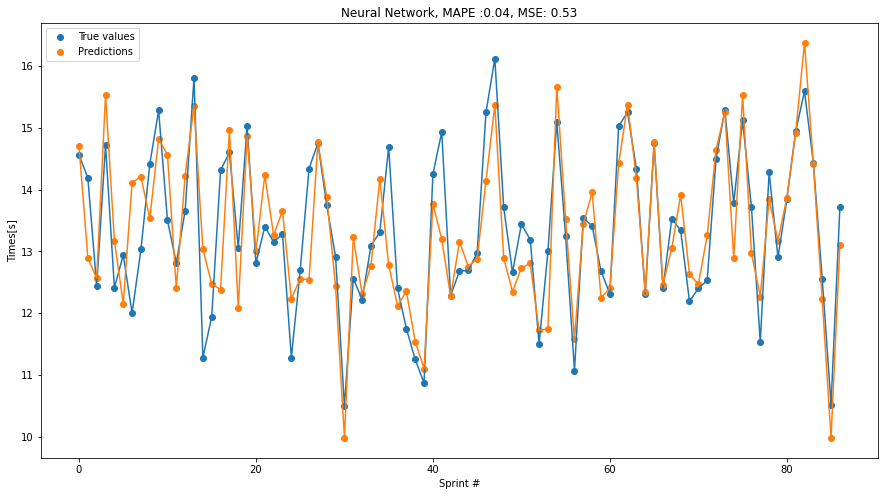

In [48]:
plot_comparison(y_pred, res_cv, model, 'Neural Network')

## Support Vector Machine

In [49]:
SVR_model = SVR()
all_models.append(SVR_model)
SVR_name ='Support Vector Machine'
y_SVR_pred, metrics_df = fit_model(SVR_model, poly_var_train, poly_var_cv, res_train, res_cv, metrics_df,SVR_name)

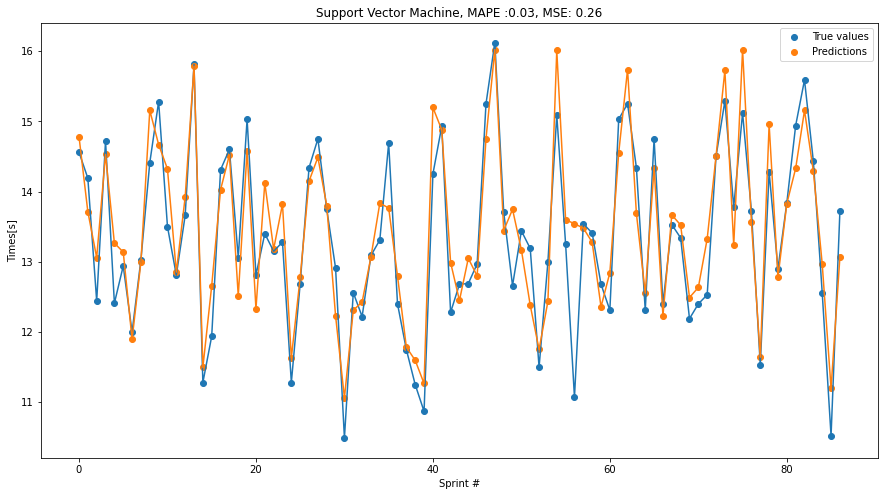

In [50]:
plot_comparison(y_lasso_pred, res_cv, SVR_model, SVR_name)

# Metrics Test Review

In [51]:
metrics_df

algorithm   MAE   MSE  MAPE  MedAE  elapsed time
0        Linear Regression  0.42  0.31  0.03   0.36         0.013
1            Random Forest  0.35  0.20  0.03   0.29         0.454
2            Decision Tree  0.40  0.28  0.03   0.34         0.006
3                     CART  0.38  0.26  0.03   0.28         0.006
4                  XGBoost  0.35  0.18  0.03   0.33         0.111
5               KNeighbors  0.49  0.38  0.04   0.43         0.100
6                    Ridge  0.41  0.29  0.03   0.33         0.011
7                    Lasso  0.41  0.29  0.03   0.35         0.003
8              Elastic Net  0.41  0.28  0.03   0.33         0.003
9           Neural Network  0.55  0.53  0.04   0.46         5.645
10  Support Vector Machine  0.40  0.26  0.03   0.35         0.007

# Inference on test set

Selectin the best test model

In [52]:
min_idx = metrics_df.MSE.argmin()
best_model = metrics_df.iloc[min_idx,:]
print('The best model on cross-validation phase is {} with a MSE of {}\n'.format(best_model.algorithm, best_model.MSE))

The best model on cross-validation phase is XGBoost with a MSE of 0.18



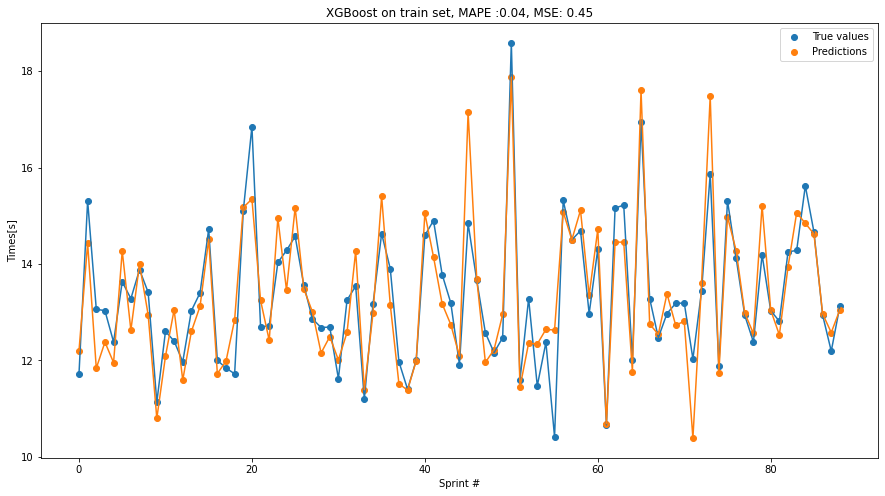

In [53]:
b_model = all_models[min_idx]

y_best_model_pred, metrics_df = fit_model(b_model, poly_var_train, poly_var_test, res_train, res_test, metrics_df,best_model.algorithm+' on train set')
plot_comparison(y_best_model_pred, res_test, b_model, best_model.algorithm+' on train set')

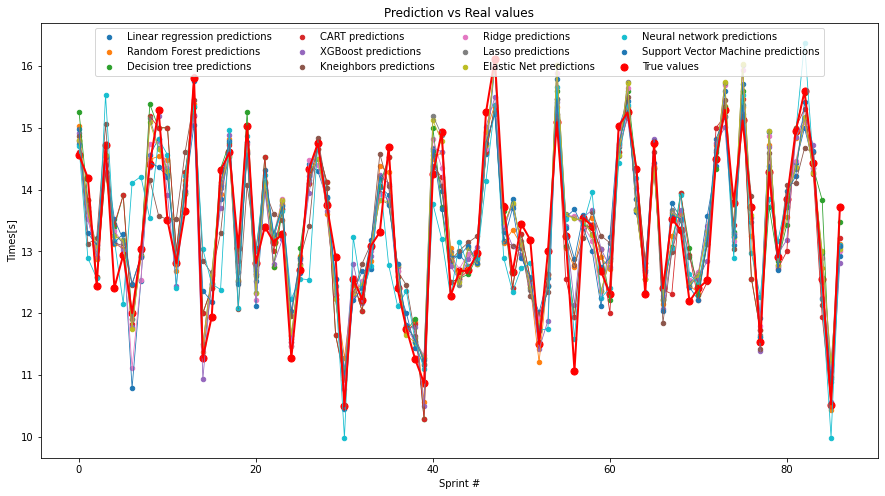

In [54]:
plt.figure(figsize=(15,8))
x_axis = np.arange(len(y_pred))

#Predicted Linear Regression
plt.scatter(x_axis, y_linear_pred, label='Linear regression predictions', s=20)
plt.plot(x_axis, y_linear_pred, linewidth=0.8)

#Predicted Random Forest
plt.scatter(x_axis, y_rf_pred, label='Random Forest predictions', s=20)
plt.plot(x_axis, y_rf_pred, linewidth=0.8)

#Predicted Decision tree
plt.scatter(x_axis, y_dec_tree_pred, label='Decision tree predictions', s=20)
plt.plot(x_axis, y_dec_tree_pred, linewidth=0.8)

#Predicted CART
plt.scatter(x_axis, y_CART_pred, label='CART predictions', s=20)
plt.plot(x_axis, y_CART_pred, linewidth=0.8)

#Predicted XGBoost
plt.scatter(x_axis, y_XGBoost_pred, label='XGBoost predictions', s=20)
plt.plot(x_axis, y_XGBoost_pred, linewidth=0.8)

#Predicted KNeighbors
plt.scatter(x_axis, y_Kneigh_pred, label='Kneighbors predictions', s=20)
plt.plot(x_axis, y_Kneigh_pred, linewidth=0.8)

#Predicted Ridge
plt.scatter(x_axis, y_ridge_pred, label='Ridge predictions', s=20)
plt.plot(x_axis, y_ridge_pred, linewidth=0.8)


#Predicted Lasso
plt.scatter(x_axis, y_lasso_pred, label='Lasso predictions', s=20)
plt.plot(x_axis, y_lasso_pred, linewidth=0.8)

#Predicted Elastic Net
plt.scatter(x_axis, y_el_net_pred, label='Elastic Net predictions', s=20)
plt.plot(x_axis, y_el_net_pred, linewidth=0.8)

#Predicted Neural Network
plt.scatter(x_axis, y_pred, label='Neural network predictions', s=20)
plt.plot(x_axis, y_pred, linewidth=0.8)


#Predicted SVM
plt.scatter(x_axis, y_SVR_pred, label='Support Vector Machine predictions', s=20)
plt.plot(x_axis, y_SVR_pred, linewidth=0.8)

#True values
plt.scatter(x_axis, res_cv, label='True values', s=50, color='red')
plt.plot(x_axis, res_cv, linewidth=2, color='red')

plt.title('Prediction vs Real values')
plt.xlabel('Sprint #')
plt.ylabel('Times[s]')
plt.legend(loc='upper center',  ncol=4)
plt.show()

In [55]:
metrics_df

algorithm   MAE   MSE  MAPE  MedAE  elapsed time
0        Linear Regression  0.42  0.31  0.03   0.36         0.013
1            Random Forest  0.35  0.20  0.03   0.29         0.454
2            Decision Tree  0.40  0.28  0.03   0.34         0.006
3                     CART  0.38  0.26  0.03   0.28         0.006
4                  XGBoost  0.35  0.18  0.03   0.33         0.111
5               KNeighbors  0.49  0.38  0.04   0.43         0.100
6                    Ridge  0.41  0.29  0.03   0.33         0.011
7                    Lasso  0.41  0.29  0.03   0.35         0.003
8              Elastic Net  0.41  0.28  0.03   0.33         0.003
9           Neural Network  0.55  0.53  0.04   0.46         5.645
10  Support Vector Machine  0.40  0.26  0.03   0.35         0.007
11    XGBoost on train set  0.50  0.45  0.04   0.42         0.124

# MODEL SELECTION: degree of the polynomial

In [56]:
metrics_degree_df = pd.DataFrame(columns = ['degree','MAE', 'MSE','MAPE','MedAE','elapsed time'])

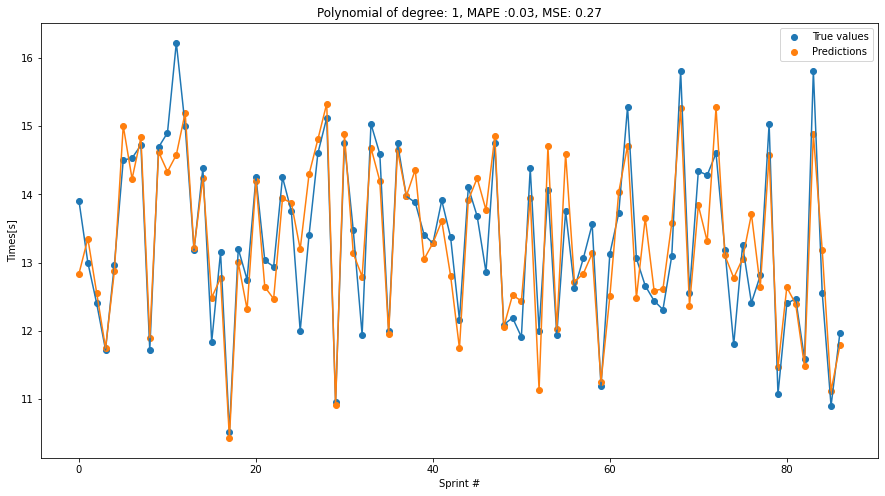

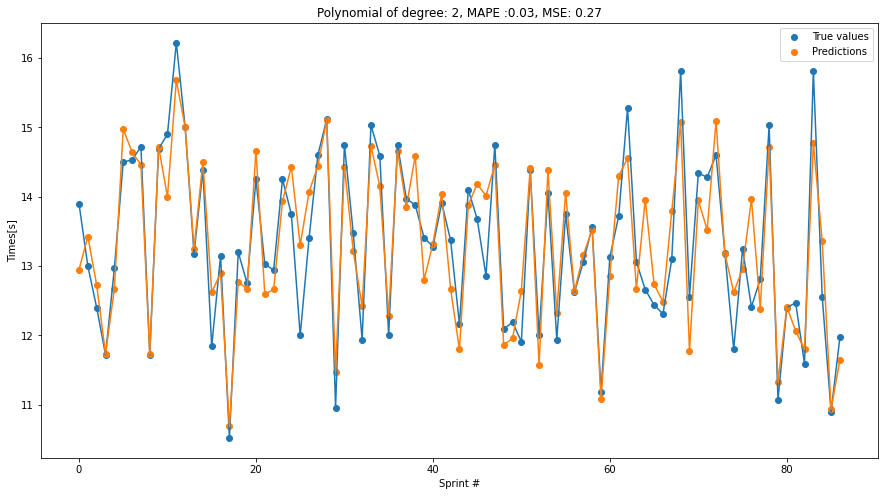

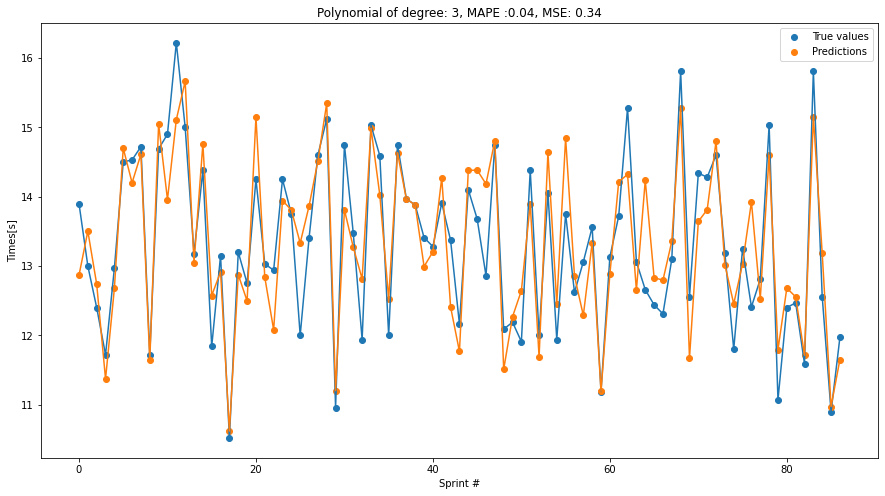

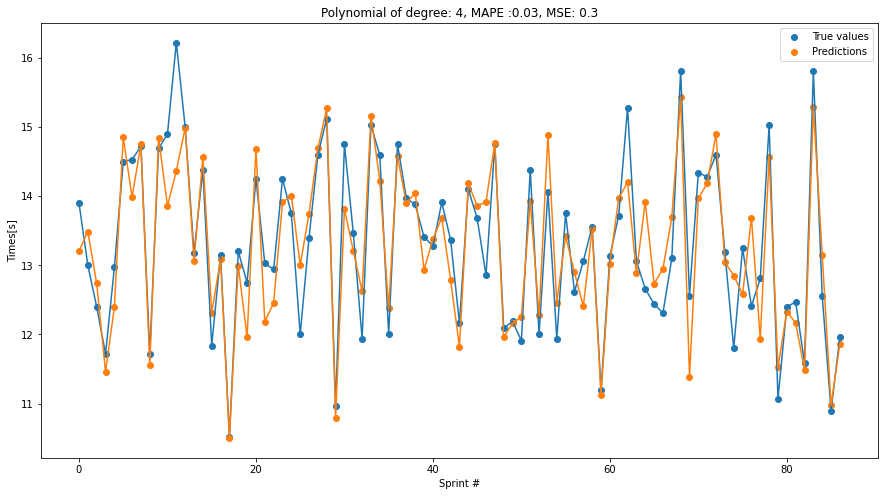

In [ ]:
catenated_df = catenated_df.sample(frac=1)
all_y_degree_pred = []
X = catenated_df.iloc[:,1:].loc[:,relevant_columns].values
y = catenated_df.iloc[:,0].values

## TRAIN, CROSS-VALIDATION AND TEST SPLIT 
#transform the x data for proper fitting (for single variable type it returns,[1,x,x**2])
poly_var_train = X[:int(len(X)*0.6),:]
res_train = y[:int(len(y)*0.6)]

poly_var_cv = X[int(len(X)*0.6):int(len(X)*0.6) + int(len(X)*0.2),:]
res_cv = y[int(len(y)*0.6):int(len(y)*0.6) + int(len(y)*0.2)]

poly_var_test = X[int(len(X)*0.6) + int(len(X)*0.2):,:]
res_test = y[int(len(y)*0.6) + int(len(y)*0.2):]

for degree in range(1,6):

    ###### DEGREE SELECTION & POLYNOMIAL FEATURES CONSTRUCTION ##########
    
    poly = PolynomialFeatures(degree=degree)
    poly_var_train_deg = poly.fit_transform(poly_var_train)
    poly_var_cv_deg = poly.fit_transform(poly_var_cv)
    poly_var_test_deg = poly.fit_transform(poly_var_test)

    # Scaling the input
    sc = StandardScaler()
    
    poly_var_train_deg = sc.fit_transform(poly_var_train_deg)
    poly_var_cv_deg = sc.transform(poly_var_cv_deg)
    poly_var_test_deg = sc.transform(poly_var_test_deg)
    
    ## FIT ##
    
    y_deg_pred, metrics_degree_df = fit_model(b_model, poly_var_train_deg, poly_var_cv_deg, res_train, res_cv, metrics_degree_df,str(degree), mode =2)
    plot_comparison(y_deg_pred, res_cv, b_model, str(degree), mode=2, metrics=metrics_degree_df)
    all_y_degree_pred.append(y_deg_pred)

In [ ]:
plt.figure(figsize=(15,8))
x_axis = np.arange(len(all_y_degree_pred[0]))

for i in range(5):
    #d=i
    plt.scatter(x_axis, all_y_degree_pred[i], label='d={}'.format(i+1), s=20)
    plt.plot(x_axis, all_y_degree_pred[i], linewidth=0.8)

#True values
plt.scatter(x_axis, res_cv, label='True values', s=50, color='red')
plt.plot(x_axis, res_cv, linewidth=2, color='red')

plt.title('Prediction vs Real values')
plt.xlabel('Sprint #')
plt.ylabel('Times[s]')
plt.legend(loc='upper center',  ncol=6)
plt.show()

In [ ]:
metrics_degree_df

# Inference on test set

Selecting the best test model 

In [ ]:
plt.figure(figsize=(15,8))

plt.scatter(metrics_degree_df.degree, metrics_degree_df.MSE)
plt.plot(metrics_degree_df.degree, metrics_degree_df.MSE, label=r'$MSE_{train}$')

plt.scatter(metrics_degree_df.MSE.argmin(), metrics_degree_df.MSE.min(), color='red', s=120)
plt.text(metrics_degree_df.MSE.argmin(), metrics_degree_df.MSE.min() + 0.01,'Optimal Degree',horizontalalignment='center', verticalalignment='center')

plt.xlabel("polynomial degree(d)", fontsize=15)
plt.ylabel("MSE", fontsize=15)
plt.legend(fontsize=15)
plt.show()

In [ ]:
metrics_degree_df

In [ ]:
min_deg_idx = metrics_degree_df.MSE.argmin()
best_deg_model = metrics_degree_df.iloc[min_deg_idx,:]
print('The best degree of the polynomial on cross-validation phase is {} with a MSE of {}\n'.format(best_deg_model.degree, best_deg_model.MSE))

In [ ]:
best_degree = best_deg_model.degree

poly = PolynomialFeatures(degree=int(best_degree))
poly_var_train_best_deg = poly.fit_transform(poly_var_train)
poly_var_cv_best_deg = poly.fit_transform(poly_var_cv)
poly_var_test_best_deg = poly.fit_transform(poly_var_test)

# Scaling the input
sc = StandardScaler()

poly_var_train_best_deg = sc.fit_transform(poly_var_train_best_deg)
poly_var_cv_best_deg = sc.transform(poly_var_cv_best_deg)
poly_var_test_best_deg = sc.transform(poly_var_test_best_deg)

## FIT ##

y_deg_pred, metrics_degree_df = fit_model(b_model, poly_var_train_best_deg, poly_var_test_best_deg, res_train, res_test, metrics_degree_df,str(best_degree)+' on test set', mode =2)
plot_comparison(y_deg_pred, res_test, b_model, str(best_degree)+' on test set', mode=2, metrics=metrics_degree_df)
